# Przetwarzanie i analiza danych obserwacji Ziemi w Pythonie
## W notatniku zawarto wszystkie komendy i funkcje związane z artykułem XYZ w czasopiśmie ZYX

Prezentowany kod pokazuje programistyczne podejście do przetwarzania danych z satelitów obserwacji Ziemi. W kodzie przetwarzan się dane z satelity Landsat 8, udostępniane przez USGS (https://www.usgs.gov/). Dane możliwe są do pobrania za pośrednictwem serwisu EarthExplorer (https://earthexplorer.usgs.gov/). Metadane przetwarzanej sceny znajdują się w oddzielnym pliku, najważniejszą kwestią jest poziom przetworzenia danych. Są one wstępnie przygotowane do analizy, ponieważ wyznaczono już współczynnik odbicia promieniowania w zakresie widzialnym i bliskiej podczerwieni (Level-2 Surface Reflectance). Więcej informacji o typie danych jak i o poszczególnych etapach ich przetwarzania w artykule XYZ, w czasopiśmie ZYX.

-----
Prawa autorskie: 

Licencja MIT
Copyright: Szymon Moliński
Użytkownik posiada nieograniczone prawo do używania, kopiowania, modyfikowania i rozpowszechniania (w tym sprzedaży) oryginalnego lub zmodyfikowanego programu w postaci binarnej lub źródłowej. Jedynym wymaganiem jest, by we wszystkich wersjach zachowano warunki licencyjne i informacje o autorze. Więcej informacji: https://opensource.org/licenses/mit-license.php


In [20]:
# Import podstawowych bibliotek

%matplotlib notebook
import os
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt

In [36]:
# Funkcja do wczytywania listy kanalow i porzadkowania jej

def wczytaj_obrazy_landsat(nazwa_folderu):
    """Funkcja zwraca słownik (dict) z parami NUMER KANAŁU: ścieżka_do_pliku
    return: {numer_kanalu: sciezka_do_pliku}"""
    lista_plikow = os.listdir(nazwa_folderu)
    lista_kanalow = []
    for plik in lista_plikow:
        if (plik.startswith('LC') and plik.endswith('.tif')):
            if 'band' in plik:
                lista_kanalow.append(nazwa_folderu + plik)             
    lista_kanalow.sort()
    numery_kanalow = np.arange(1, 8)
    slownik_z_lista_kanalow = dict(zip(numery_kanalow, lista_kanalow))
    return slownik_z_lista_kanalow

# pliki = wczytaj_obrazy_landsat('LC081880252013080701T1-SC20180329040242/')

In [50]:
# Funkcja do wyświetlania poszczególnych obrazów

def wyswietl_obraz(obraz, mapa_kolorow='gray'):
    fig = plt.figure(figsize=(8,8))
    warstwa_obrazu = plt.imshow(obraz)
    warstwa_obrazu.set_cmap(mapa_kolorow)  # inne mapy kolorów: winter, viridis, plasma, PRGn
    plt.colorbar()

In [45]:
# Funkcja do wycinania fragmentów rastra na podstawie szablonu z pliku wektorowego

In [46]:
# Funkcja do obliczania wskaźników

def oblicz_wskaznik(kanal_a, kanal_b):
    wskaznik_licznik = (kanal_a - kanal_b)
    wskaznik_mianownik = (kanal_a + kanal_b)
    wskaznik_macierz = np.zeros(kanal_a.shape)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        wskaznik_macierz = wskaznik_licznik / wskaznik_mianownik
        wskaznik = np.nan_to_num(wskaznik_macierz)
        wskaznik[wskaznik > 1] = 0
    return wskaznik

<IPython.core.display.Javascript object>


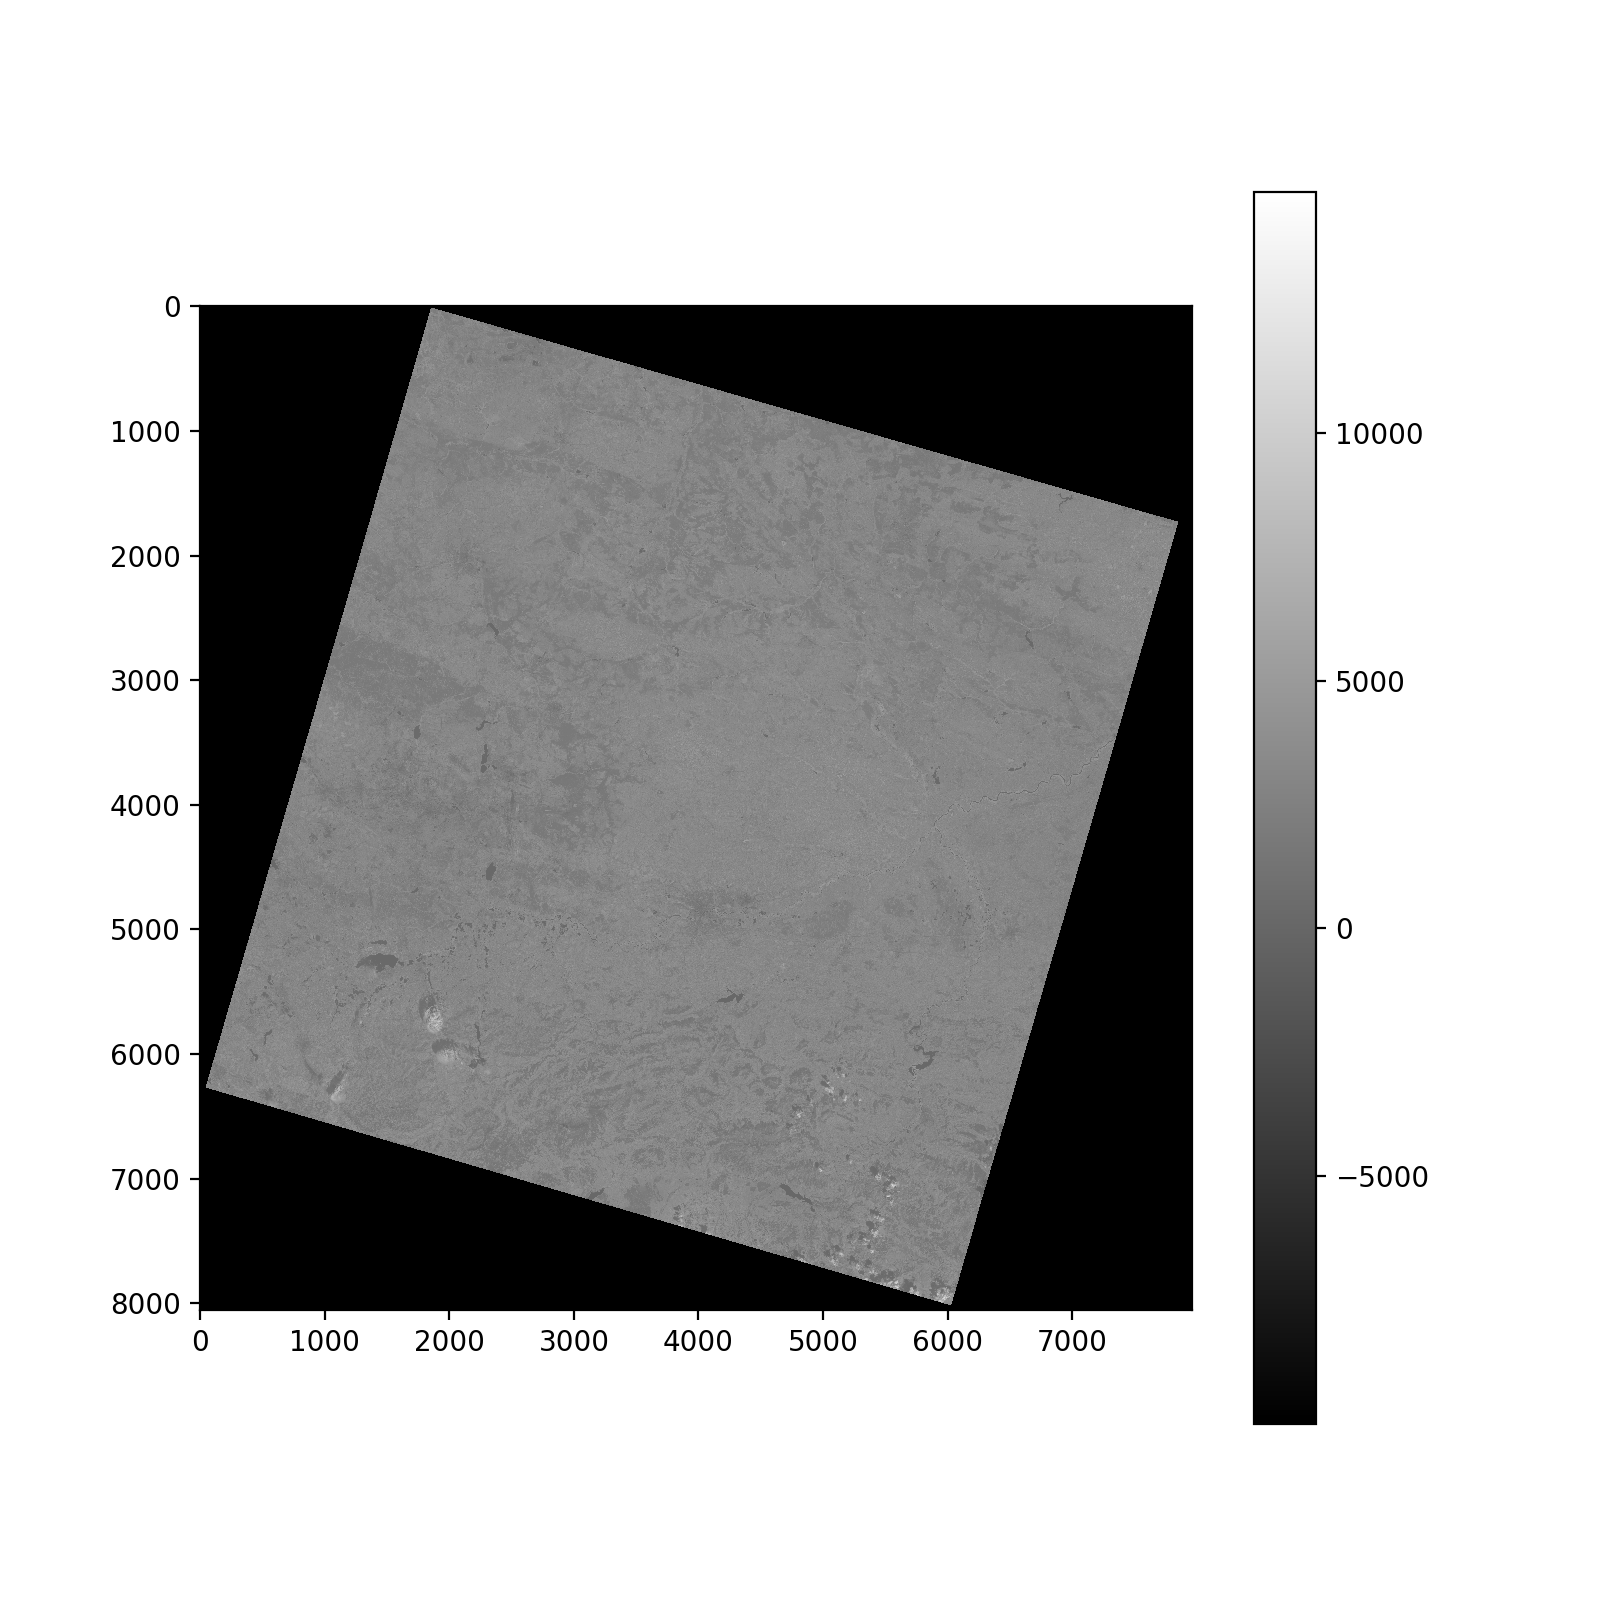

In [62]:
# Pierwsze kroki: wczytanie obrazu i jego wyświetlenie

kanal_piaty = rio.open('LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band5.tif')
macierz_kanalu = kanal_piaty.read(1)
wyswietl_obraz(macierz_kanalu)

<IPython.core.display.Javascript object>


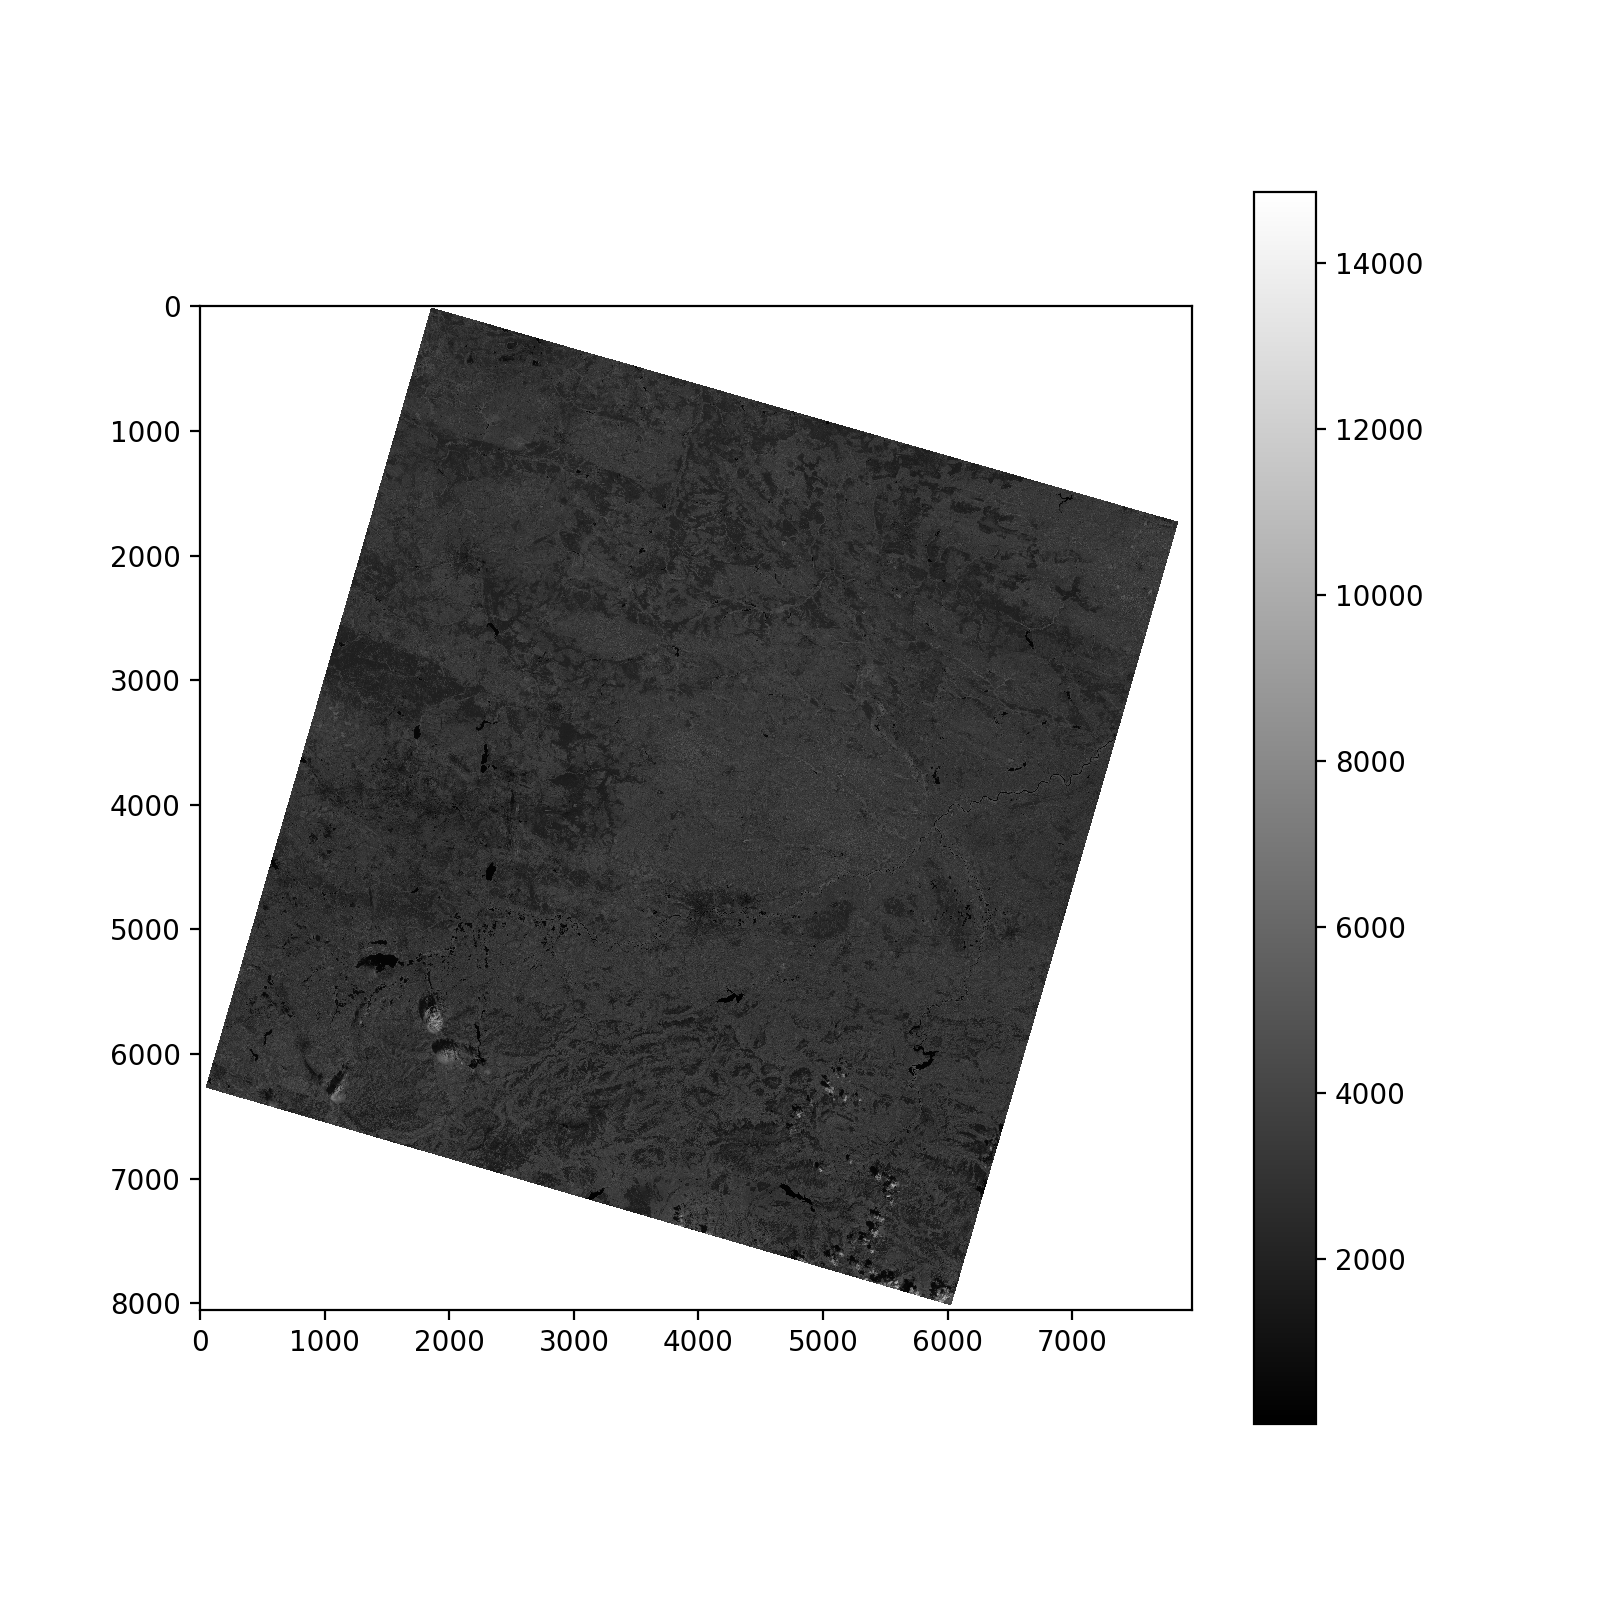

In [64]:
# Skąd wartości mniejsze niż zero? - oznaczają one niewypełnione piksele (NaN) i nie powinny być używane

macierz_bez_minus = macierz_kanalu.astype(float)
macierz_bez_minus[macierz_bez_minus < 0] = np.nan
wyswietl_obraz(macierz_bez_minus)

## Obszar zainteresowań ma znacznie

Zdjęcia satelitarne nie są przetwarzane "w całości" lecz z uwzględnieniem obszaru, dla którego prowadzimy obserwacje. O ile obszarem nie jest terytorium całej Polski, Europy albo świata, nie obrabia się tak dużych rastrów. Obszar zaintersowania można wyodrębnić na wiele sposobów, ale najbardziej użyteczne jest wykorzystywanie plików wektorów odwzorowujących granice administracyjne. Jednym problemem, któremu trzeba poświęcić szczególną uwagę, jest rodzaj projekcji danych. Funkcja wycinająca obszar zaintersowania musi też porównać typ projekcji między rastrem i wektorem. W przypadku niedopasowania projekcji, zawsze należy przetwarzać dane WEKTOROWE, ponieważ każda zmiana projekcji danych rastrowych skutkuje zniekształceniami wartości danych.